# Linear Regression

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

In [2]:
import yfinance as yf

# Load and prepare data
ticker = "SPY"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)

# Create features and target
data['Returns'] = data['Close'].pct_change()
data['Volume_MA'] = data['Volume'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_50'] = data['Close'].rolling(50).mean()

# Calculate RSI manually
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['Close'])

# Calculate MACD manually
def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line - signal_line

data['MACD'] = calculate_macd(data['Close'])

# Clean data and prepare for modeling
clean_data = data[['Returns', 'Volume_MA', 'SMA_10', 'SMA_50', 'RSI', 'MACD']].dropna()
X = clean_data[['Volume_MA', 'SMA_10', 'SMA_50', 'RSI', 'MACD']]
y = clean_data['Returns']

print(f"Clean dataset shape: {clean_data.shape}")
print(f"Features: {list(X.columns)}")

/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_21526/3623713259.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)


Clean dataset shape: (2215, 6)
Features: [('Volume_MA', ''), ('SMA_10', ''), ('SMA_50', ''), ('RSI', ''), ('MACD', '')]


## Baseline model fit

In [4]:
# Split data chronologically (time-series aware)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")
print(f"Coefficients: {dict(zip(X.columns, model.coef_))}")

Train set: (1772, 5), Test set: (443, 5)
R² Score: 0.0586
RMSE: 0.011732
Coefficients: {('Volume_MA', ''): np.float64(1.8983199771066583e-11), ('SMA_10', ''): np.float64(-0.0001040661385954197), ('SMA_50', ''): np.float64(0.00010798751352643749), ('RSI', ''): np.float64(0.0001630148104335202), ('MACD', ''): np.float64(0.0009903370907916615)}


In [5]:
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred

# Residual analysis metrics
residual_mean = residuals.mean()
residual_std = residuals.std()
residual_skew = stats.skew(residuals)
residual_kurtosis = stats.kurtosis(residuals)

print(f"Residual Mean: {residual_mean:.6f} (should be ~0)")
print(f"Residual STD: {residual_std:.6f}")
print(f"Residual Skewness: {residual_skew:.4f}")
print(f"Residual Kurtosis: {residual_kurtosis:.4f}")

Residual Mean: -0.000334 (should be ~0)
Residual STD: 0.011740
Residual Skewness: 0.0155
Residual Kurtosis: 1.4178


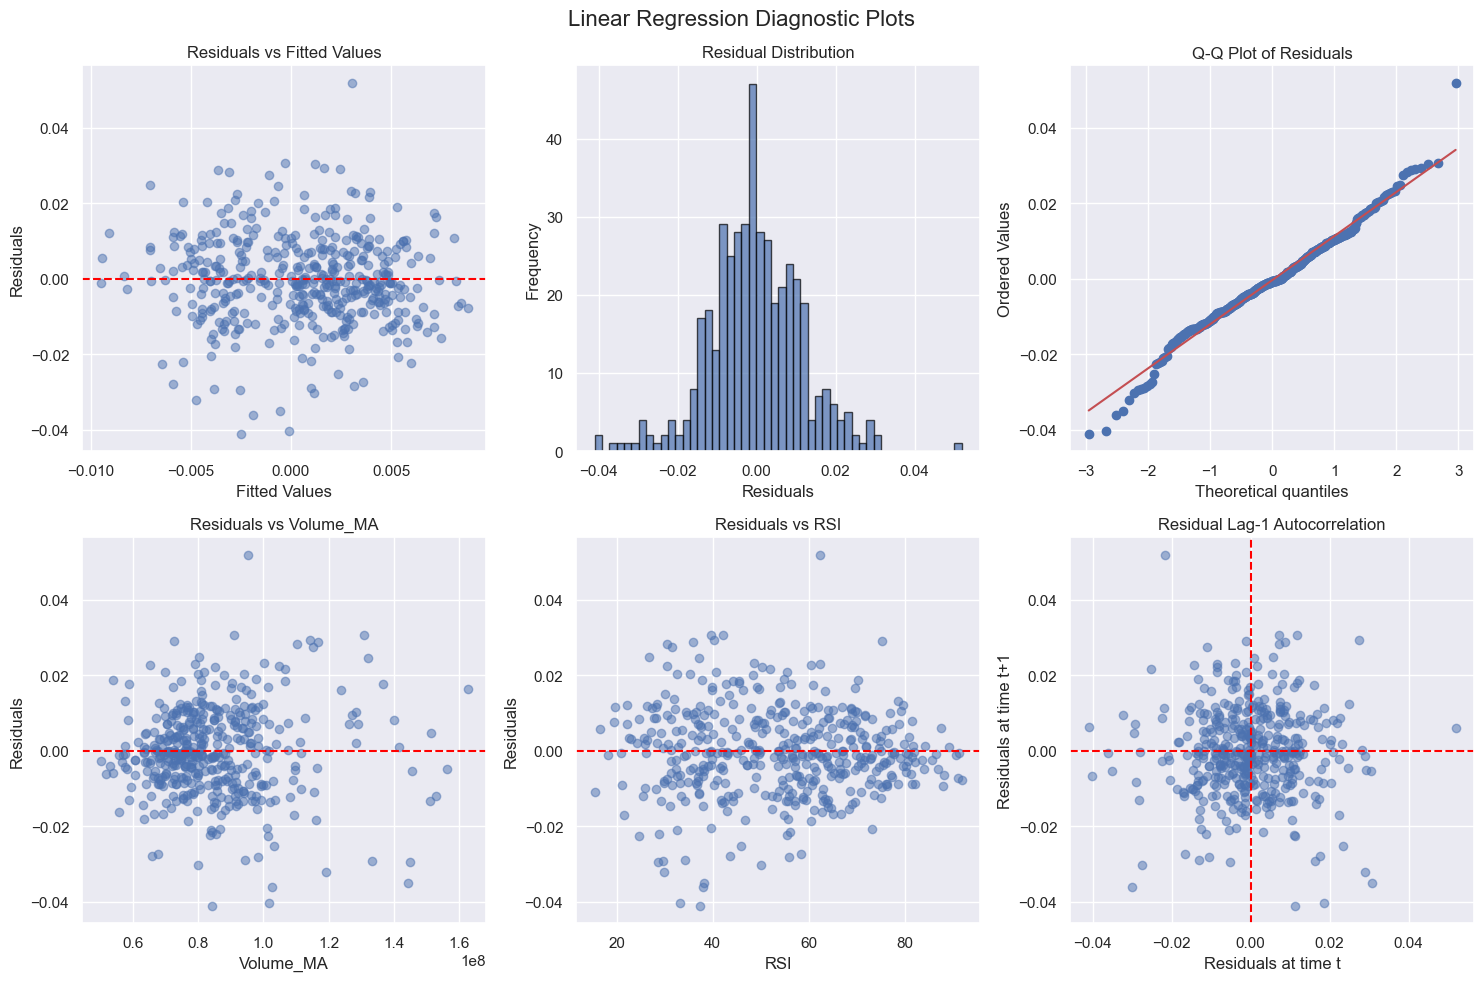

In [6]:
# Create diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Linear Regression Diagnostic Plots', fontsize=16)

# 1. Residuals vs Fitted Values
axes[0,0].scatter(y_pred, residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted Values')

# 2. Histogram of Residuals
axes[0,1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Residual Distribution')

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot of Residuals')

# 4. Residuals vs Volume_MA (key predictor)
axes[1,0].scatter(X_test['Volume_MA'], residuals, alpha=0.5)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Volume_MA')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals vs Volume_MA')

# 5. Residuals vs RSI
axes[1,1].scatter(X_test['RSI'], residuals, alpha=0.5)
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('RSI')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs RSI')

# 6. Lag-1 Residual Autocorrelation
axes[1,2].scatter(residuals[:-1], residuals[1:], alpha=0.5)
axes[1,2].axhline(y=0, color='red', linestyle='--')
axes[1,2].axvline(x=0, color='red', linestyle='--')
axes[1,2].set_xlabel('Residuals at time t')
axes[1,2].set_ylabel('Residuals at time t+1')
axes[1,2].set_title('Residual Lag-1 Autocorrelation')

plt.tight_layout()
plt.show()

## Add a transformed feature

In [7]:
# Try squared RSI feature (capture non-linear effects)
X_transformed = X.copy()
X_transformed['RSI_Squared'] = X['RSI'] ** 2

# Split transformed data
X_train_trans, X_test_trans = X_transformed.iloc[:split_idx], X_transformed.iloc[split_idx:]

# Refit model
model_trans = LinearRegression()
model_trans.fit(X_train_trans, y_train)
y_pred_trans = model_trans.predict(X_test_trans)

# Compare performance
r2_trans = r2_score(y_test, y_pred_trans)
rmse_trans = np.sqrt(mean_squared_error(y_test, y_pred_trans))

print(f"Original R²: {r2:.4f}, Transformed R²: {r2_trans:.4f}")
print(f"Original RMSE: {rmse:.6f}, Transformed RMSE: {rmse_trans:.6f}")

Original R²: 0.0586, Transformed R²: 0.0530
Original RMSE: 0.011732, Transformed RMSE: 0.011767


## Interpretation 
- Linearity: The residuals vs. fitted plot shows that the residual values should be randomly scattered around 0, meaning that the linearity condition is satisfied. 
- Homoscedasticity: Based on observing the residual values being randomly scattered around 0 from the residuals vs. fitted plot, we can also determine that the condition of homoscedasticity is satisfied. 
- Normality: The histogram visualizing the distribution of residuals shows that the distribution appears to be roughly symmetric, and the data points on the QQ plot appear to roughly follow a straight line, so the condition of normality is satisfied. 
- Independence: The data points in the residual lag-1 autocorrelation plot appear to be randomly scattered but with some minor clustering, there could be some potential time-series dependencies between predictors. 
- Which model do you trust and why?: Both the original and transformed regression model have low R-squared values, meaning that very little variability (only around 5 percent) in returns is explained by the predictors, and there are potential time-series dependencies, so linear regression may not be the best modeling approach for this data. 
- Next step you’d try: As for next steps, I would look into alternative modeling strategies, such as random forests, logistic regression, or LSTMs.